In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
cd '/gdrive/My Drive/Colab Notebooks/gene_gsp_classification/'

/gdrive/My Drive/Colab Notebooks/gene_gsp_classification


In [ ]:
from scipy import stats

In [ ]:
import numpy as np
import pandas as pd
import os
import copy
from IPython.display import Image
from datetime import datetime

from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import ShuffleSplit

from torchvision import datasets, transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset
writer = SummaryWriter()

## DFT

In [ ]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

In [ ]:
ar = 0
ag = 0 
ab = 1

tr = 0.911
tg = -0.244
tb = -0.333

cr = 0.244
cg = 0.911
cb = -0.333

gr = -0.817
gg = -0.800 # -0.800
gb = 0 #0

In [ ]:
ls nucleosome/

C_elegans.csv            final_melanogaster.csv      melanogaster_spect_sft/
C_elegans_spect/         final_melanogaster_dft.csv  models/
C_elegans_spect_dft/     final_melanogaster_sft.csv  sapiens.csv
C_elegans_spect_sft/     final_sapiens.csv           sapiens.gsheet
Data/                    final_sapiens_dft.csv       sapiens_spect/
data_creation.ipynb      final_sapiens_sft.csv       sapiens_spect_dft/
final_C_elegans.csv      melanogaster.csv            sapiens_spect_sft/
final_C_elegans_dft.csv  melanogaster_spect/         txt2data.py
final_C_elegans_sft.csv  melanogaster_spect_dft/


In [ ]:
data = pd.read_csv('nucleosome/sapiens.csv')
len(os.listdir("nucleosome/sapiens_spect_sft/"))

FileNotFoundError: ignored

In [ ]:
len(data)

4573

In [ ]:
rm -rf nucleosome/sapiens_spect_sft/

In [ ]:
mkdir nucleosome/melanogaster_spect_sft/

In [ ]:
path = []

root = 'nucleosome/melanogaster_spect_sft/'
for datanum in range(len(data)):
  gene = data["gene_sequences"][datanum]
  gene_seq = gene
  type_gene = ''
  if (data["label"][datanum]=='Nucleosome_Forming'):
    type_gene = 'form'
  elif (data["label"][datanum]=='Nucleosome_Inhibiting'):
    type_gene = 'inhib'
  
  print(datanum)

  u_a = []
  u_t = []
  u_g = []
  u_c = []
  for nuc in gene:
    if(nuc=='A'):
      u_a.append(1)
      u_t.append(0)
      u_g.append(0)
      u_c.append(0)

    elif(nuc=='T'):
      u_a.append(0)
      u_t.append(1)
      u_g.append(0)
      u_c.append(0)

    elif(nuc=='G'):
      u_a.append(0)
      u_t.append(0)
      u_g.append(1)
      u_c.append(0)

    elif(nuc=='C'):
      u_a.append(0)
      u_t.append(0)
      u_g.append(0)
      u_c.append(1)

  x_r = []
  x_g = []
  x_b = []
  for i in range(len(u_c)):

    x_r.append(ar*u_a[i] + tr*u_t[i] + cr*u_c[i] + gr*u_g[i])
    x_g.append(ag*u_a[i] + tg*u_t[i] + cg*u_c[i] + gg*u_g[i])
    x_b.append(ab*u_a[i] + tb*u_t[i] + cb*u_c[i] + gb*u_g[i])

  #X_r = DFT(x_r)
  #X_g = DFT(x_g)
  #X_b = DFT(x_b)

  #f, t, Zxx = signal.stft(x_r, 1,window='hann', nperseg=1)
  #X_r = np.abs(Zxx).reshape(-1)
  #f, t, Zxx = signal.stft(x_g, 1,window='hann', nperseg=1)
  #X_g = np.abs(Zxx).reshape(-1)
  #f, t, Zxx = signal.stft(x_b, 1,window='hann', nperseg=1)
  #X_b = np.abs(Zxx).reshape(-1)

  f, t, Zxx = signal.stft(x_r, 1,window='hann', nperseg=9,noverlap=6)
  X_r = np.abs(Zxx)
  f, t, Zxx = signal.stft(x_g, 1,window='hann', nperseg=9,noverlap=6)
  X_g = np.abs(Zxx)
  f, t, Zxx = signal.stft(x_b, 1,window='hann', nperseg=9,noverlap=6)
  X_b = np.abs(Zxx)

  spectogram = []

  for i in range(len(f)):
    spectogram_x = []
    for j in range(len(t)):
      spectogram_x.append([X_r[i][j],X_g[i][j],X_b[i][j]])
    spectogram.append(spectogram_x)
  spectogram = np.array(spectogram,dtype=object)
  spectogram_norm = ((spectogram - spectogram.min())/(spectogram.max() - spectogram.min()))*255
  image_pixels = spectogram_norm 
  
  '''
  spectogram = []
  for i in range(len(X_r)):
    spectogram.append([np.linalg.norm(X_r[i]),np.linalg.norm(X_g[i]),np.linalg.norm(X_b[i])])
  spectogram = np.array(spectogram)

  spectogram_norm = ((spectogram - spectogram.min())/(spectogram.max() - spectogram.min()))*255
  image_pixels = np.reshape(spectogram_norm, (21, -1,3))
  '''
  image_pixels = np.array(image_pixels, dtype=np.uint8)
  img = Image.fromarray(image_pixels)

  img_reshape = img.resize((224,224))

  image_path = os.path.join(root,type_gene+'_' + str(datanum))
  print(image_path)
  path.append(image_path+'.png')

  img_reshape.save(image_path+'.png')

In [ ]:
len(path)

5750

In [ ]:
ls nucleosome/

C_elegans.csv            final_melanogaster.csv      melanogaster_spect_sft/
C_elegans_spect/         final_melanogaster_dft.csv  models/
C_elegans_spect_dft/     final_melanogaster_sft.csv  sapiens.csv
C_elegans_spect_sft/     final_sapiens.csv           sapiens.gsheet
Data/                    final_sapiens_dft.csv       sapiens_spect/
data_creation.ipynb      final_sapiens_sft.csv       sapiens_spect_dft/
final_C_elegans.csv      melanogaster.csv            sapiens_spect_sft/
final_C_elegans_dft.csv  melanogaster_spect/         txt2data.py
final_C_elegans_sft.csv  melanogaster_spect_dft/


In [ ]:
data['path'] = path
data.to_csv("nucleosome/final_melanogaster_sft.csv")

## FUNCTIONS

In [ ]:
ham = signal.get_window('hamming', 25)
def get_spectogram(gene_seq,path):
  f, t, Sxx = signal.spectrogram(np.array(gene_seq), fs=1, window = ham, mode = 'magnitude')
  #plt.pcolormesh(t, f, Sxx,vmin = np.min(Sxx), vmax = np.max(Sxx))
  plt.pcolormesh(t, f, Sxx)
  plt.ylabel('Frequency [Hz]')
  plt.xlabel("Nucleotide Positions")
  plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
  plt.axis('tight')
  plt.axis('off')
  plt.savefig(path+'.png', dpi=300, frameon='false')

In [ ]:
def gene_tag(gene):
  gene_seq = []
  for i in range(len(gene)):
    if (gene[i]=="T"):
      gene_seq.append(0)
    elif (gene[i]=="G"):
      gene_seq.append(3)
    elif (gene[i]=="C"):
      gene_seq.append(1)
    elif (gene[i]=="A"):
      gene_seq.append(2)
  return gene_seq

### CREATING THE SPECTOGRAMS

In [ ]:
data = pd.read_csv('nucleosome/sapiens.csv')

In [ ]:
len(os.listdir("nucleosome/sapiens_spect/"))

4576

In [ ]:
#rm -rf nucleosome/sapiens_spect/*

In [ ]:
len(data)

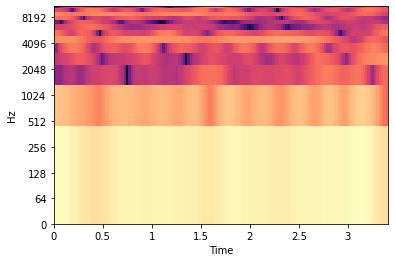

In [ ]:
import librosa
window_size = 25
gene = data["gene_sequences"][0]
gene_seq = gene_tag(gene)
window = np.hamming(window_size)
out  = librosa.core.spectrum.stft(np.array(np.array(gene_seq).astype(np.float)), n_fft = window_size, hop_length = 1, 
       window=window)
out = 2 * np.abs(out) / np.sum(window)

import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(out,ref=np.max),
               y_axis='log', x_axis='time')

In [ ]:
path = []
root = 'nucleosome/sapiens_spect/'
for i in range(len(data)):
  gene = data["gene_sequences"][i]
  gene_seq = gene_tag(gene)
  type_gene = ''
  if (data["label"][i]=='Nucleosome_Forming'):
    type_gene = 'form'
  elif (data["label"][i]=='Nucleosome_Inhibiting'):
    type_gene = 'inhib'
  image_path = os.path.join(root,type_gene+'_' + str(i))
  print(image_path)
  path.append(image_path+'.png')
  print(i)
  #get_spectogram(gene_seq,image_path)
  

Streaming output truncated to the last 5000 lines.
nucleosome/sapiens_spect/form_2073
2073
nucleosome/sapiens_spect/form_2074
2074
nucleosome/sapiens_spect/form_2075
2075
nucleosome/sapiens_spect/form_2076
2076
nucleosome/sapiens_spect/form_2077
2077
nucleosome/sapiens_spect/form_2078
2078
nucleosome/sapiens_spect/form_2079
2079
nucleosome/sapiens_spect/form_2080
2080
nucleosome/sapiens_spect/form_2081
2081
nucleosome/sapiens_spect/form_2082
2082
nucleosome/sapiens_spect/form_2083
2083
nucleosome/sapiens_spect/form_2084
2084
nucleosome/sapiens_spect/form_2085
2085
nucleosome/sapiens_spect/form_2086
2086
nucleosome/sapiens_spect/form_2087
2087
nucleosome/sapiens_spect/form_2088
2088
nucleosome/sapiens_spect/form_2089
2089
nucleosome/sapiens_spect/form_2090
2090
nucleosome/sapiens_spect/form_2091
2091
nucleosome/sapiens_spect/form_2092
2092
nucleosome/sapiens_spect/form_2093
2093
nucleosome/sapiens_spect/form_2094
2094
nucleosome/sapiens_spect/form_2095
2095
nucleosome/sapiens_spect/form

In [ ]:
data['path'] = path

In [ ]:
data.to_csv("nucleosome/final_sapeins.csv")

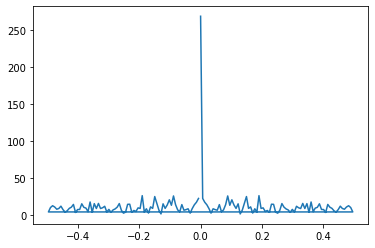

In [ ]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 147

yf = fft(gene_seq)
xf = fftfreq(N, 1)

plt.plot(xf, np.abs(yf))
plt.show()


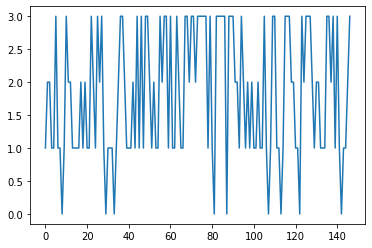

In [ ]:
plt.plot(np.arange(147) , gene_seq)

In [ ]:
y, sr = librosa.load(librosa.ex('trumpet'))

librosa.feature.melspectrogram(y=y, sr=sr)

NameError: ignored